# Individualized iRF for the enhancer data
For a particular data unit, collect all the paths on which this particular unit falls and look for the intersections.


### load packages

In [32]:
require('iRF')
require('dplyr')
require('mclust')

Loading required package: mclust
Package 'mclust' version 5.4
Type 'citation("mclust")' for citing this R package in publications.


### load the data

In [3]:
load('./individual_enhancer.RData')
load('./enhancer.Rdata')

### set figure size

In [65]:
options(repr.plot.width = 4, repr.plot.height=4)

### predefined functions 

In [34]:
index2names <- function(strs, name.list) {
    # change a integer string to meaningful names
    #  for example, change "45 64" to "Kr Twi"
    if (length(strs) > 0 && class(strs[0]) == 'factor') {
        strs = as.character(strs)
    }
    return(strs %>% strsplit(' ') %>%
    lapply(FUN = as.numeric) %>%
    lapply(FUN = function(x) name.list[x]) %>%
    sapply(FUN = function(x) paste(x, collapse = ' ')))
}
multi.modality.test <- function(data) {
    # return the log.likelihood ratio between 2 Gaussian mixitures and 1 Gaussian
    log.likelihood2 <- Mclust(data, G = 2, verbose = F)$loglik
    log.likelihood1 <- Mclust(data, G = 1, verbose = F)$loglik
    return(log.likelihood2 - log.likelihood1)
}


           
           

## Individualized iRF 
- For each sample, select all the RF paths that it falls into and transform them into boolean vectors showing what features are splitted.
- Find their intersections with high prevalence.
- Currently, the intersections are found using apriori (exact method) with prevalence larger than .1

## Result analysis

We can get the intersection for each data unit, the output is a data frame with two columns:

In [28]:
out.list[[1]] %>% mutate(Interaction = index2names(Interaction, varnames.all[[1]])) %>% tail

,Interaction,Prevalence
480,wt_ZLD bcd2 gt2 kr1 twi1,0.110
481,wt_ZLD bcd2 kr1 twi1 twi2,0.110
482,bcd2 gt2 kr1 twi1 twi2,0.130
483,wt_ZLD bcd2 gt2 kr1 twi2,0.126
484,wt_ZLD bcd2 gt2 twi1 twi2,0.172
485,wt_ZLD gt2 kr1 twi1 twi2,0.166


As we get the intersections for each data unit, we collect all the prevalences for each intersections and investigate into its distribution patterns.

In [ ]:
interaction.freq = list()
for (out in out.list) {
  out$Interaction <- as.character(out$Interaction)
  for (row.index in 1:nrow(out)) {
    comb <- out$Interaction[row.index]
    if (comb %in% names(interaction.freq)) {
      interaction.freq[[comb]] = c(interaction.freq[[comb]], out$Prevalence[row.index])
    } else {
      interaction.freq[[comb]] = c(out$Prevalence[row.index])
    }
  }
}

In [49]:
sprintf('The number of interactions is %d', length(interaction.freq))

[1] "The number of interactions is 3064"

### Interesting multi-modality pattern in 'wt_ZLD twi2'
The histogram of 'wt_ZLD gt2 kr1' exhibits a clear two-modality pattern. It means for some samples this interaction is not that often while for some other samples this interaction becomes very important for classification.

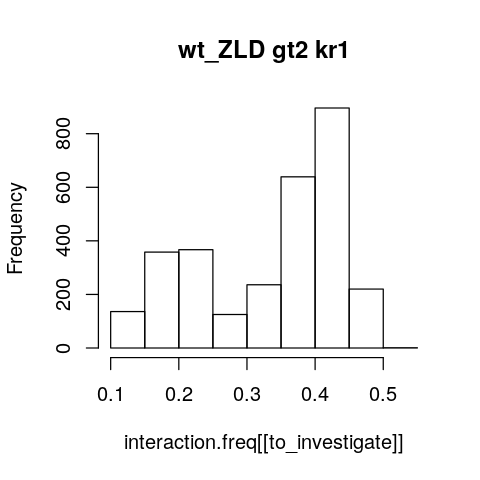

In [69]:
to_investigate = '46 54 64'
hist(interaction.freq[[to_investigate]], main = index2names(to_investigate, varnames.all[[1]]))

### investigate other interactions that has multi-modality
Multi-modality is measured by a **likelihood ratio** between Gaussian with 2 mixuters and Gaussian with 1 mixiture.

tmp <- lapply(interaction.freq, function(x) multi.modality.test(x))

In [ ]:
# find the maximum value in tmp
max(do.call('rbind', tmp), na.rm = T)

In [60]:
data.frame(Interaction = index2names(names(tmp[tmp > .18]), varnames.all[[1]]), 
           Indices = names(tmp[tmp > .18]),
           Score = unlist(tmp[tmp > .18], use.names = F)) %>% arrange(desc(Score))

Interaction,Indices,Score
wt_ZLD kr1,46 64,0.2030967
wt_ZLD twi2,46 79,0.2017701
wt_H3K4me1 twi2,45 79,0.2002126
D1 twi2,50 79,0.1986016
D1 gt2,50 54,0.1945462
kr1 twi2,64 79,0.1939697
gt2 kr1 twi2,54 64 79,0.1928205
wt_ZLD gt2 kr1,46 54 64,0.1894278
wt_ZLD,46,0.1860757
gt2 kr1,54 64,0.1812387


### Multi-modality gives some meaningful interactions
'wt_ZLD gt2 kr1' appears in the list. Let's take a look at the other distributions

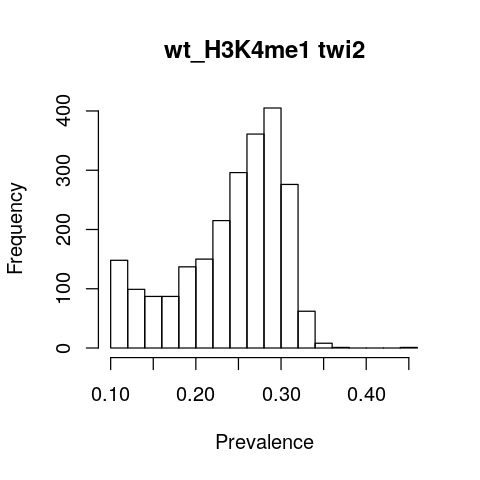

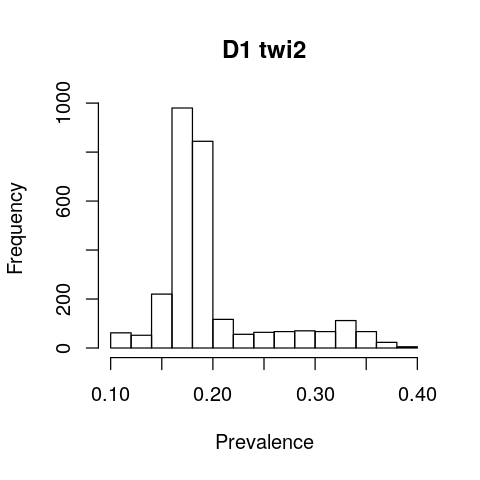

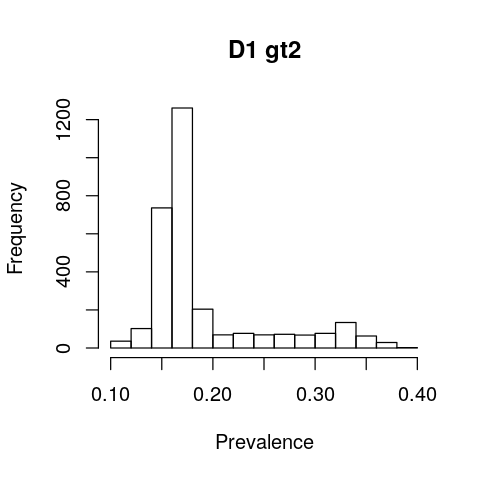

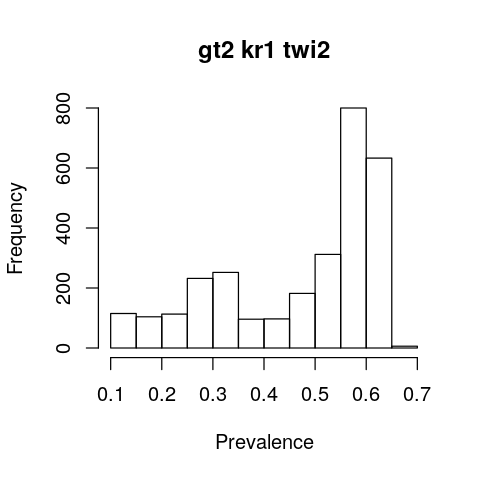

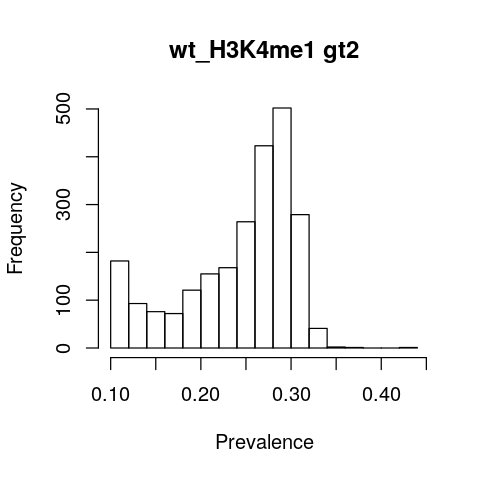

In [72]:
for (to_investigate in c('45 79', '50 79', '50 54', '54 64 79', '45 54')) {
    hist(interaction.freq[[to_investigate]], main = index2names(to_investigate, varnames.all[[1]]), xlab = 'Prevalence')
}